In [1]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import copy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from itertools import chain, combinations

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\195707809.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



# Preprocessing

In [2]:
# Load in data
pd.set_option('display.max_columns', None)

clients = pd.read_csv("data/companies.csv")
data = pd.read_csv("data/deals.csv")

# Replace deals with price 0 as NA
data.loc[data['Amount']==0, 'Amount'] = np.nan

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\2625798249.py:5: DtypeWarning: Columns (5,8,23,24,36,42,45,49,50,64,66,69,75,79,83,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/deals.csv")


In [3]:
# Appending industry information to the main dataframe 
associated_ID = pd.to_numeric(data['Associated Company ID'], errors='coerce').convert_dtypes() 
lookup_ID = clients['Company ID'].astype('Int64')
industry = []
revenue = []
nview = []
nemployee = []
founded = []

assoc_deals = []; times_contacted = []; og_source = []; form_submissions = [];
state = []; country = []; managers = []; public = [];


for i in tqdm(range(data.shape[0])):
    search_ID = associated_ID.loc[i]
    try:
        industry.append(clients.loc[clients['Company ID']==search_ID,'Industry'].values[0])
        revenue.append(clients.loc[clients['Company ID']==search_ID,'Annual Revenue'].values[0])
        nview.append(clients.loc[clients['Company ID']==search_ID,'Number of Pageviews'].values[0])
        nemployee.append(clients.loc[clients['Company ID']==search_ID,'Number of Employees'].values[0])
        founded.append(clients.loc[clients['Company ID']==search_ID,'Year Founded'].values[0])
        
        assoc_deals.append(clients.loc[clients['Company ID']==search_ID,'Associated Deals'].values[0])
        times_contacted.append(clients.loc[clients['Company ID']==search_ID,'Number of times contacted'].values[0])
        og_source.append(clients.loc[clients['Company ID']==search_ID,'Original Source Type'].values[0])
        form_submissions.append(clients.loc[clients['Company ID']==search_ID,'Number of Form Submissions'].values[0])
        state.append(clients.loc[clients['Company ID']==search_ID,'State/Region'].values[0])
        country.append(clients.loc[clients['Company ID']==search_ID,'Country/Region'].values[0])
        managers.append(clients.loc[clients['Company ID']==search_ID,'Number of managers'].values[0])
        public.append(clients.loc[clients['Company ID']==search_ID,'Is Public'].values[0])

    except:
        industry.append(np.nan)
        revenue.append(np.nan)
        nview.append(np.nan)
        nemployee.append(np.nan)
        founded.append(np.nan)

        assoc_deals.append(np.nan)
        times_contacted.append(np.nan)
        og_source.append(np.nan)
        form_submissions.append(np.nan)
        state.append(np.nan)
        country.append(np.nan)
        managers.append(np.nan)
        public.append(np.nan)


data['Industry'] = industry
data['Revenue'] = revenue
data['Nview'] = nview
data['Nemployee'] = nemployee
data['Founded'] = founded

data['Adeals'] = assoc_deals; data['Ncontacted'] = times_contacted; data['Source'] = og_source; data['Nform'] = form_submissions; 
data['State'] = state; data['Country'] = country; data['Nmanagers'] = managers; data['Public'] = public; 

  0%|          | 0/9064 [00:00<?, ?it/s]

In [4]:
# Creating response variable 
success = ['(CA) Invoice Paid',
 '(CA) Invoice Sent',
 '(CA) Onboarding Completed',
 '(CA) Paid + Scheduling Sent',
 '(CA) Paid + TBD Workshops',
 '(CA) Scheduling Completed',
 '(CA) Scheduling Initiated',
 '(PC) Closed Won/Handed off to Scheduling']
fail = ['Closed Lost']
pending = ['(PC) Expressed Interest',
 '(PC) Handed off to CA (Legal)',
 '(PC) Likely to close in next two weeks',
 '(PC) Proposal Sent']

binary = copy.copy(data['Deal Stage'])
binary[data['Deal Stage'].isin(success)] = 1
binary[data['Deal Stage'].isin(fail)] = 0
binary[data['Deal Stage'].isin(pending)] = np.nan
data['Binary'] = binary
data['Binary'] = pd.to_numeric(data['Binary'], errors='coerce').convert_dtypes() 

#Creating Customer Size variable
data['Customer Size'] = copy.copy(data['Amount'])/2500
data['Customer Size'] = data['Customer Size'].apply(np.ceil)

In [5]:
price = []
size = []
ps = [2200,2300,2400,2500,2700,2900]
cuts = [np.inf,250,100,50,20,10,1]
for i in tqdm(range(data.shape[0])):
    # if data['Pricing Model'][i] == 'Org Wide Pricing':
        try:
            r = data['Amount'][i]//ps
            for j in range(len(r)):
                r[j] *= ((r[j] < cuts[j]) & (cuts[j+1] <= r[j]))
            price.append(ps[r.argmax()])
            size.append(max(r))
        except:
            price.append(np.nan)
            size.append(np.nan)
    # else:
    #     price.append(np.nan)
    #     size.append(np.nan)
data['Price'] = price
data['Size'] = size

  0%|          | 0/9064 [00:00<?, ?it/s]

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\1682519215.py:8: RuntimeWarning: invalid value encountered in floor_divide
  r = data['Amount'][i]//ps


In [6]:
group = []
for i in range(len(data['Size'])):
    if (data['Size'].iloc[i] < 20) & (0 <= data['Size'].iloc[i]):
        group.append(0)
    elif (data['Size'].iloc[i] < 50) & (20 <= data['Size'].iloc[i]):
        group.append(1)
    elif (50 <= data['Size'].iloc[i]):
        group.append(2)
    else:
        group.append(np.nan)
data['Group'] = group

In [7]:
# data = data.loc[data['Close Date'] > np.datetime64('2019-12-31')]
data = data.loc[data['Revenue year'] > 2019]

In [8]:
# data.to_csv('data/data_processed.csv', index=False)

# Summary

In [9]:
data.describe().round(3)

,Deal ID,Total Count of Products,Revenue year,Closed Won Reason,Annual contract value,Unscheduled Workshops,Weighted amount in company currency,Next step,Campaign of last booking in meetings tool,Forecast probability,Air Travel (US or Canada),Number of times contacted,Number of Sales Activities,Recurring revenue deal type,Forecast amount,Off-Hours Workshops (6am-9am or 6pm-10pm),Medium of last booking in meetings tool,Invoice Amount Billed,# of Learners,Annual recurring revenue,Avatar Workshops,All-staff Workshops,Total Quantity of Products,Source of last booking in meetings tool,EMEA Workshops,Number of Associated Contacts,Weighted amount,Total contract value,Recurring revenue inactive reason,Total Number of Events Attended Pre-client,Deal probability,# of Cohorts,In-Person Workshops,Deal Year,Off Off-Hours Workshops,Amount,Priority,Virtual Workshops,Monthly recurring revenue,International Travel (ex-Canada),Regional Travel,Manager Workshops,Recurring revenue inactive date,Total Number of Events Attended Post-client,Blended Workshops,Company Year,Recurring revenue amount,APAC Workshops,Exec Workshops,Amount in company currency,Approximate # of Learners,Revenue,Nview,Nemployee,Founded,Adeals,Ncontacted,Nform,Binary,Customer Size,Price,Size,Group
count,6.615000e+03,6615.000,6615.000,0.0,4442.000,1482.000,5559.000,0.0,0.0,6615.000,1622.000,6538.000,6538.000,0.0,5559.000,1656.000,0.0,2134.000,2523.000,4442.0,1602.000,2501.000,4442.000,0.0,1736.000,6615.000,5559.000,4442.000,0.0,6494.000,6615.000,5136.000,1606.000,6615.000,1630.000,5553.000,0.0,1590.000,4442.0,1367.0,1621.000,2509.000,0.0,1845.000,1580.000,6600.000,0.0,1681.000,2499.000,5559.000,2494.000,5.947000e+03,6551.000,6485.000,6178.000,6570.000,6568.000,6441.000,5948.0,5553.000,6615.000,5553.000,5553.000
mean,4.052099e+09,2.420,2020.613,NaN,23605.464,4.487,9990.917,NaN,NaN,0.402,0.009,18.006,31.594,NaN,9893.407,0.313,NaN,16543.606,66.134,0.0,0.002,2.262,8.397,NaN,0.865,1.338,9990.917,23605.464,NaN,0.289,0.405,4.878,0.097,2020.478,0.044,23575.293,NaN,8.211,0.0,0.0,0.004,4.856,NaN,0.883,0.022,2019.368,NaN,0.410,0.295,23549.847,118.356,1.639279e+08,87.242,1405.216,2001.302,4.811,105.962,17.503,0.409,9.828,2721.421,8.864,0.142
std,1.750378e+09,2.963,0.494,NaN,45220.104,137.380,24718.319,NaN,NaN,0.467,0.225,20.699,38.046,NaN,24603.902,2.390,NaN,21098.107,140.250,0.0,0.050,5.398,16.948,NaN,4.976,0.709,24718.319,45220.104,NaN,0.766,0.468,202.348,0.824,0.621,0.420,45229.872,NaN,13.885,0.0,0.0,0.089,10.922,NaN,1.107,0.439,1.588,NaN,2.043,1.556,45212.081,204.315,3.194633e+08,142.720,6140.064,29.679,5.749,144.020,18.584,0.492,18.015,269.567,19.690,0.424
min,4.002946e+08,0.000,2020.000,NaN,12.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,NaN,0.000,0.000,NaN,0.000,0.000,0.0,0.000,0.000,1.000,NaN,0.000,0.000,0.000,12.000,NaN,0.000,0.000,0.000,0.000,2016.000,0.000,12.000,NaN,0.000,0.0,0.0,-1.000,0.000,NaN,0.000,0.000,2015.000,NaN,0.000,0.000,0.000,0.000,1.000000e+06,0.000,1.000,1630.000,1.000,0.000,0.000,0.0,1.000,2200.000,0.000,0.000
25%,2.471144e+09,0.000,2020.000,NaN,5800.000,0.000,0.000,NaN,NaN,0.000,0.000,6.000,9.000,NaN,0.000,0.000,NaN,2900.000,20.000,0.0,0.000,0.000,2.000,NaN,0.000,1.000,0.000,5800.000,NaN,0.000,0.000,0.000,0.000,2020.000,0.000,5800.000,NaN,2.000,0.0,0.0,0.000,0.000,NaN,0.000,0.000,2019.000,NaN,0.000,0.000,5800.000,30.000,1.000000e+07,14.000,65.000,2003.000,1.000,23.000,5.000,0.0,3.000,2500.000,2.000,0.000
50%,4.055064e+09,1.000,2021.000,NaN,14500.000,0.000,2900.000,NaN,NaN,0.000,0.000,12.000,19.000,NaN,2900.000,0.000,NaN,11600.000,30.000,0.0,0.000,1.000,5.000,NaN,0.000,1.000,2900.000,14500.000,NaN,0.000,0.000,1.000,0.000,2021.000,0.000,12500.000,NaN,5.000,0.0,0.0,0.000,1.000,NaN,1.000,0.000,2020.000,NaN,0.000,0.000,12500.000,60.000,5.000000e+07,43.000,200.000,2011.000,3.000,59.000,12.000,0.0,5.000,2900.000,4.000,0.000
75%,5.535773e+09,5.000,2021.000,NaN,27000.000,0.000,12500.000,NaN,NaN,1.000,0.000,23.000,41.000,NaN,11930.000,0.000,NaN,21200.000,60.000,0.0,0.00

In [10]:
data.head()

,Deal ID,Special Codes,Primary Location,Total Count of Products,Revenue year,Travel Expenses,Closed Won Reason,Annual contract value,Workshop Location,Last Modified Date,Unscheduled Workshops,Offsite / Events,Pipeline,Weighted amount in company currency,Invoice Status,Audience,Next step,Program,Campaign of last booking in meetings tool,Forecast probability,Air Travel (US or Canada),Close Date,Deal Type,Program Start Date,SOW Deal Amount,Number of times contacted,Number of Sales Activities,Recurring revenue deal type,Deal Split Added,Original Source Type,Forecast amount,Off-Hours Workshops (6am-9am or 6pm-10pm),Medium of last booking in meetings tool,Invoice Amount Billed,# of Learners,Create Date,Date of last meeting booked in meetings tool,Invoice Due Date,Custom SOW Template,Closed Lost Reason,Annual recurring revenue,Avatar Workshops,Deal Payment Terms,Client Type,Deal owner,Services Rescheduling Deadline,All-staff Workshops,Total Quantity of Products,Last Activity Date,Next Activity Date,Pricing Model,No Intake Call Reason,Source of last booking in meetings tool,Owner Assigned Date,EMEA Workshops,Deal Stage,Number of Associated Contacts,Weighted amount,Total contract value,Recurring revenue inactive reason,Total Number of Events Attended Pre-client,Last Contacted,Deal probability,HubSpot Team,Deal Bracket,# of Cohorts,Flag - has * product line item,In-Person Workshops,Deal Year,Services Commencement Date,Off Off-Hours Workshops,Flag - has Exec/All-Staff/IC product line item,Amount,Priority,Virtual Workshops,Legal Contract,Client Administrator,Monthly recurring revenue,International Travel (ex-Canada),Ideal start month,Regional Travel,Manager Workshops,Recurring revenue inactive date,Services Expiration Date,Total Number of Events Attended Post-client,Blended Workshops,Forecast category,Company Year,Recurring revenue amount,APAC Workshops,Exec Workshops,Amount in company currency,Approximate # of Learners,Workshop Format,Associated Company ID,Industry,Revenue,Nview,Nemployee,Founded,Adeals,Ncontacted,Source,Nform,State,Country,Nmanagers,Public,Binary,Customer Size,Price,Size,Group
0,6746637364,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-24 15:49,NaN,No,Booking Pipeline,528000.0,NaN,Manager; Exec,NaN,Manager Core 1,NaN,0.4,NaN,2021-11-30 18:32,Returning,NaN,NaN,9.0,11.0,NaN,False,Direct Traffic,528000.0,NaN,NaN,NaN,NaN,2021-10-25 08:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blue,Joie Lim,NaN,NaN,NaN,2021-11-24 15:49,NaN,CORE Pricing,NaN,NaN,2021-10-26 08:22,NaN,(PC) Proposal Sent,2,528000.0,NaN,NaN,0.0,2021-11-24 15:49,0.4,Program Consultants,$251k+,100.0,NaN,NaN,2021,NaN,NaN,NaN,1320000.0,NaN,NaN,NaN,Juliana Baumann,NaN,NaN,January,NaN,NaN,NaN,NaN,NaN,NaN,Best case,2020.0,NaN,NaN,NaN,1320000.0,NaN,Virtual,4527772700,Information Technology and Services,1.000000e+09,37.0,5500.0,2010.0,3.0,34.0,Organic Search,3.0,Daerah Khusus Ibukota Jakarta,Indonesia,1300,False,<NA>,528.0,2200,600.0,2.0
1,5348381233,NaN,San Francisco,5,2021.0,NaN,NaN,1100000.0,NaN,2021-09-06 15:09,NaN,No,Booking Pipeline,0.0,NaN,Manager,NaN,Manager Core 1,NaN,0.0,NaN,2021-08-05 00:08,New Business,NaN,NaN,12.0,16.0,NaN,False,Direct Traffic,0.0,NaN,NaN,NaN,NaN,2021-05-25 16:49,2021-06-07 09:30,NaN,NaN,Chose different Vendor,0.0,NaN,NaN,Blue,Jamie Brancazio,NaN,NaN,500.0,2021-07-29 20:21,NaN,CORE Pricing,NaN,NaN,2021-07-02 08:12,NaN,Closed Lost,2,0.0,1100000.0,NaN,0.0,2021-07-29 20:21,0.0,Program Consultants,$251k+,100.0,NaN,NaN,2021,NaN,NaN,NaN,1100000.0,NaN,NaN,NaN,Genevieve McGahey,0.0,NaN,October,NaN,NaN,NaN,NaN,NaN,NaN,Not forecasted,2021.0,NaN,NaN,NaN,1100000.0,NaN,Virtual,3134102126,Financial Services,1.000000e+09,15.0,22000.0,1958.0,1.0,20.0,Direct Traffic,6.0,CA,United States,4000,True,0,440.0,2200,500.0,2.0
2,6120720003,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-12 10:51,NaN,No,Booking Pipeline,248400.0,NaN,Manager,NaN,Manager Core 1,NaN,0.4,NaN,2021-11-30 18:32,Returning,NaN,NaN,15.0,22.0,NaN,False,Offline Sources,248400.0,NaN,NaN,NaN,NaN,2021-09-02 10:23,2021-1

In [11]:
data.info(verbose=True, memory_usage='deep', show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6615 entries, 0 to 8897
Data columns (total 113 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    Deal ID                                         6615 non-null   int64  
 1    Special Codes                                   780 non-null    object 
 2    Primary Location                                6596 non-null   object 
 3    Total Count of Products                         6615 non-null   int64  
 4    Revenue year                                    6615 non-null   float64
 5    Travel Expenses                                 3 non-null      object 
 6    Closed Won Reason                               0 non-null      float64
 7    Annual contract value                           4442 non-null   float64
 8    Workshop Location                               330 non-null    object 
 9    Last Modified Date          

In [16]:
set(data.Industry)

{'*Commercial & Professional Services',
 '*Health Care Equipment & Services',
 '*Interactive Media & Services',
 '*Internet & Direct Marketing Retail',
 '*Media',
 'Accounting',
 'Airlines/Aviation',
 'Animation',
 'Apparel & Fashion',
 'Architecture & Planning',
 'Automotive',
 'Aviation & Aerospace',
 'Banking',
 'Biotechnology',
 'Broadcast Media',
 'Building Materials',
 'Business Supplies and Equipment',
 'Chemicals',
 'Civic & Social Organization',
 'Civil Engineering',
 'Commercial Real Estate',
 'Computer & Network Security',
 'Computer Games',
 'Computer Hardware',
 'Computer Networking',
 'Computer Software',
 'Construction',
 'Consumer Electronics',
 'Consumer Goods',
 'Consumer Services',
 'Cosmetics',
 'Defense & Space',
 'Design',
 'E-Learning',
 'Education Management',
 'Electrical/Electronic Manufacturing',
 'Entertainment',
 'Environmental Services',
 'Events Services',
 'Facilities Services',
 'Farming',
 'Financial Services',
 'Fine Art',
 'Food & Beverages',
 'Food 

In [17]:
data.groupby('Industry').count()['Deal ID'].sort_values(ascending=False).head(10)

Industry
Computer Software                      2404
Marketing and Advertising               292
Financial Services                      280
Information Technology and Services     207
Hospital & Health Care                  188
Biotechnology                           151
Health, Wellness and Fitness            142
Non-Profit Organization Management      128
Retail                                  121
Insurance                               120
Name: Deal ID, dtype: int64

In [18]:
data.groupby('Industry').sum('Amount')['Amount'].sort_values(ascending=False).head(10)

Industry
Computer Software                      49704200.00
Financial Services                      6640200.00
Marketing and Advertising               5279800.00
Information Technology and Services     4535400.00
Hospital & Health Care                  3396377.78
Biotechnology                           3177600.00
Insurance                               2583900.00
Health, Wellness and Fitness            2526510.00
Non-Profit Organization Management      2292800.00
Food & Beverages                        2134800.00
Name: Amount, dtype: float64

# Industry Classification

The industries are classified according to [North American Industry Classification System (NAICS)](https://www.census.gov/naics/?58967?yearbck=2022). Detailed Information includes:

| Group | Sector | Definition|
| :-: | :-: | :-- |
|   | 11 | Agriculture, Forestry, Fishing and Hunting |
| 1 | 21 | Mining, Quarrying, and Oil and Gas Extraction |
|   | 22 | Utilities |
|   | 23 | Construction |
| 2 | 31-33 | Manufacturing |
| 3 | 42 | Wholesale Trade |
|   | 44-45 | Retail Trade |
|   | 48-49 | Transportation and Warehousing |
| 4 | 51 | Information |
| 5 | 52 | Finance and Insurance |
|   | 53 | Real Estate and Rental and Leasing |
| 6 | 54 | Professional, Scientific, and Technical Services (Computer Software) |
| 7 | 54 | Professional, Scientific, and Technical Services (Except CS) |
|   | 55 | Management of Companies and Enterprises |
|   | 56 | Administrative and Support and Waste Management and Remediation Services |
| 8 | 61 | Educational Services |
|   | 62 | Health Care and Social Assistance |
| 9 | 71 | Arts, Entertainment, and Recreation |
|   | 72 | Accommodation and Food Services |
| 10 | 81 | Other Services (except Public Administration) |
|   | 92 | Public Administration |

In [12]:
# Industry group dict: {Group: Industry}
group_ind = {
 "Group1": ['Farming',
            'Aviation & Aerospace',
            'Automotive',
            'Building Materials',
            'Business Supplies and Equipment',
            'Chemicals',
            'Construction',
            'Consumer Electronics',
            'Consumer Goods',
            'Defense & Space',
            'Electrical/Electronic Manufacturing',
            'Food Production',
            'Furniture',
            'Glass, Ceramics & Concrete',
            'Machinery',
            'Medical Devices',
            'Mining & Metals',
            'Oil & Energy',
            'Packaging and Containers',
            'Pharmaceuticals',
            'Printing',
            'Semiconductors',
            'Sporting Goods',
            'Textiles',
            'Tobacco',
            'Utilities',
            'Wine and Spirits'],
 "Group2": ['*Internet & Direct Marketing Retail',
            'Airlines/Aviation',
            'Apparel & Fashion',
            'Cosmetics',
            'Luxury Goods & Jewelry',
            'Package/Freight Delivery',
            'Retail',
            'Transportation/Trucking/Railroad',
            'Wholesale'],
 "Group3": ['*Media',
            'Animation',
            'Broadcast Media',
            'Computer Games',
            'Information Services',
            'Information Technology and Services',
            'Internet',
            'Libraries',
            'Media Production',
            'Motion Pictures and Film',
            'Newspapers',
            'Online Media',
            'Publishing',
            'Telecommunications',
            'Wireless'],
 "Group4": ['Banking',
            'Commercial Real Estate',
            'Financial Services',
            'Insurance',
            'Investment Banking',
            'Investment Management',
            'Real Estate',
            'Venture Capital & Private Equity'],
 "Group5": ['Computer Software'],
 "Group6": ['*Commercial & Professional Services',
            'Accounting',
            'Architecture & Planning',
            'Biotechnology',
            'Civil Engineering',
            'Computer & Network Security',
            'Computer Hardware',
            'Computer Networking',
            'Design',
            'Environmental Services',
            'Human Resources',
            'Industrial Automation',
            'Law Practice',
            'Legal Services',
            'Logistics and Supply Chain',
            'Management Consulting',
            'Market Research',
            'Marketing and Advertising',
            'Mechanical or Industrial Engineering',
            'Nanotechnology',
            'Non-Profit Organization Management',
            'Photography',
            'Public Relations and Communications',
            'Renewables & Environment',
            'Research',
            'Security and Investigations',
            'Think Tanks',
            'Translation and Localization',
            'Veterinary',
            'Facilities Services',      
            'Fund-Raising',
            'Staffing and Recruiting',
            'Writing and Editing'],
 "Group7": ['*Health Care Equipment & Services',
            'E-Learning',
            'Education Management',
            'Health, Wellness and Fitness',
            'Higher Education',
            'Hospital & Health Care',
            'Hospitality',
            'Medical Practice',
            'Mental Health Care',
            'Primary/Secondary Education'],
 "Group8": ['*Interactive Media & Services',
            'Civic & Social Organization',
            'Consumer Services',
            'Entertainment',
            'Events Services',
            'Fine Art',
            'Food & Beverages',
            'Government Administration',
            'Government Relations',
            'Individual & Family Services',
            'International Affairs',
            'International Trade and Development',
            'Law Enforcement',
            'Leisure, Travel & Tourism',
            'Museums and Institutions',
            'Music',
            'Performing Arts',
            'Philanthropy',
            'Political Organization',
            'Professional Training & Coaching',
            'Public Policy',
            'Public Safety',
            'Recreational Facilities and Services',
            'Religious Institutions',
            'Restaurants',
            'Sports']
}

In [13]:
# Check if all the industries were included
lst = []
for i in group_ind.values():
    lst += i

set(data.Industry).difference(set(lst))

{nan}

In [14]:
# Convert {Group: Industry} to {Industry: Group}
ind_group = {}
for g, lst in group_ind.items():
    for ind in lst:
        ind_group[ind] = g

In [15]:
group_ind = {
 "Group1": ['Construction',
            'Mining & Metals',
            'Oil & Energy',
            'Utilities'],
 "Group2": ['Automotive',
            'Electrical/Electronic Manufacturing',
            'Food Production',
            'Glass, Ceramics & Concrete',
            'Packaging and Containers',
            'Printing',
            'Textiles'],
 "Group3": ['*Internet & Direct Marketing Retail',
            'Package/Freight Delivery',
            'Retail',
            'Transportation/Trucking/Railroad',
            'Wholesale'],
 "Group4": ['*Media',
            'Animation',
            'Broadcast Media',
            'Information Services',
            'Information Technology and Services',
            'Internet',
            'Libraries',
            'Media Production',
            'Motion Pictures and Film',
            'Newspapers',
            'Online Media',
            'Publishing',
            'Telecommunications',
            'Wireless'],
 "Group5": ['Banking',
            'Commercial Real Estate',
            'Financial Services',
            'Insurance',
            'Investment Banking',
            'Investment Management',
            'Real Estate',
            'Venture Capital & Private Equity'],
 "Group6": ['Computer Software'],
 "Group7": ['*Commercial & Professional Services',
            'Accounting',
            'Architecture & Planning',
            'Design',
            'Human Resources',
            'Industrial Automation',
            'Law Practice',
            'Legal Services',
            'Logistics and Supply Chain',
            'Management Consulting',
            'Market Research',
            'Marketing and Advertising',
            'Mechanical or Industrial Engineering',
            'Non-Profit Organization Management',
            'Photography',
            'Public Relations and Communications',
            'Research',
            'Think Tanks',
            'Translation and Localization',
            'Veterinary',
            'Facilities Services',      
            'Fund-Raising',
            'Staffing and Recruiting',
            'Writing and Editing'],
 "Group8": ['*Health Care Equipment & Services',
            'E-Learning',
            'Education Management',
            'Health, Wellness and Fitness',
            'Higher Education',
            'Hospital & Health Care',
            'Hospitality',
            'Medical Practice',
            'Mental Health Care',
            'Primary/Secondary Education'],
 "Group9": ['Fine Art',
            'Entertainment',
            'Leisure, Travel & Tourism',
            'Museums and Institutions',
            'Performing Arts',
            'Recreational Facilities and Services',
            'Restaurants'],
 "Group10": ['Civic & Social Organization',
             'Government Administration',
             'Government Relations',
             'International Affairs',
             'International Trade and Development',
             'Law Enforcement',
             'Philanthropy',
             'Political Organization',
             'Public Policy',
             'Public Safety',
             'Religious Institutions'],
 "Group11": ['Farming',
            'Aviation & Aerospace',
            'Building Materials',
            'Business Supplies and Equipment',
            'Chemicals',
            'Consumer Electronics',
            'Consumer Goods',
            'Defense & Space',
            'Furniture',
            'Machinery',
            'Medical Devices',
            'Pharmaceuticals',
            'Semiconductors',
            'Sporting Goods',
            'Tobacco',
            'Wine and Spirits',
            'Airlines/Aviation',
            'Apparel & Fashion',
            'Cosmetics',
            'Luxury Goods & Jewelry',
            'Computer Games',
            'Biotechnology',
            'Civil Engineering',
            'Computer & Network Security',
            'Computer Hardware',
            'Computer Networking',
            'Environmental Services',
            'Nanotechnology',
            'Renewables & Environment',
            'Security and Investigations',
            'Events Services',
            '*Interactive Media & Services',
            'Consumer Services',
            'Individual & Family Services',
            'Music',
            'Food & Beverages',
            'Professional Training & Coaching',
            'Sports']
}

ind_group = {}
for g, lst in group_ind.items():
    for ind in lst:
        ind_group[ind] = g

In [19]:
tps = []
for k, v in ind_group.items():
    tps.append((v, k))
index = pd.MultiIndex.from_tuples(tps, names=('Group', 'Industry'))
print(pd.DataFrame(index=index).to_latex())

\begin{tabular}{ll}
\toprule
        &        \\
Group & Industry \\
\midrule
Group1 & Construction \\
        & Mining \& Metals \\
        & Oil \& Energy \\
        & Utilities \\
Group2 & Automotive \\
        & Electrical/Electronic Manufacturing \\
        & Food Production \\
        & Glass, Ceramics \& Concrete \\
        & Packaging and Containers \\
        & Printing \\
        & Textiles \\
Group3 & *Internet \& Direct Marketing Retail \\
        & Package/Freight Delivery \\
        & Retail \\
        & Transportation/Trucking/Railroad \\
        & Wholesale \\
Group4 & *Media \\
        & Animation \\
        & Broadcast Media \\
        & Information Services \\
        & Information Technology and Services \\
        & Internet \\
        & Libraries \\
        & Media Production \\
        & Motion Pictures and Film \\
        & Newspapers \\
        & Online Media \\
        & Publishing \\
        & Telecommunications \\
        & Wireless \\
Group5 & Banking \\
  

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\1334112550.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(index=index).to_latex())


# Regression

## Dataset

In [21]:
reg_data = copy.copy(data[['Binary', 'Revenue', 'Nview', 'Nemployee', 'Founded', 'Revenue year',
                           'Size', 'Price', 'Adeals', 'Ncontacted', 'Nform', 'State', 'Country',
                           'Nmanagers', 'Public', 'Group', 'Industry', 'Amount']])
reg_data['LogRevenue'] = np.log(reg_data['Revenue'])
# reg_data['Amount'] = np.log(reg_data['Amount'])
reg_data['LogNview'] = np.log(reg_data['Nview']+1)
reg_data['LogNemployee'] = np.log(reg_data['Nemployee']+1)
reg_data['LogAdeals'] = np.log(reg_data['Adeals']+1)
reg_data['LogNcontacted'] = np.log(reg_data['Ncontacted']+1)
# reg_data['Nmanagers'] = np.log(reg_data['Nmanagers']+1)
reg_data['LogRevperemp'] = np.log(reg_data['Revenue']/reg_data['Nemployee'])
reg_data['Founded'] = np.log(2022-reg_data['Founded'])
reg_data['Revenue year'] = reg_data['Revenue year'].astype('int')
reg_data = reg_data.dropna()
reg_data['Public'] = reg_data.Public.astype(int)
groups = pd.get_dummies(reg_data['Group'])
reg_data['Medium'] = groups.iloc[:,1] 
reg_data['Large'] = groups.iloc[:,2]
times = pd.get_dummies(reg_data['Revenue year'])
reg_data['Year'] = times.iloc[:,1]

reg_data['LogSize'] = np.log(reg_data.Size + 1)
reg_data['USfirm'] = np.where(reg_data.Country.isin(['USA', 'United States', 'United States of America']), 1, 0)
reg_data['Binary'] = reg_data.Binary.astype(int)

reg_data.describe()

,Binary,Revenue,Nview,Nemployee,Founded,Revenue year,Size,Price,Adeals,Ncontacted,Nform,Public,Group,Amount,LogRevenue,LogNview,LogNemployee,LogAdeals,LogNcontacted,LogRevperemp,Medium,Large,Year,LogSize,USfirm
count,3223.000000,3.223000e+03,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3.223000e+03,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000,3223.000000
mean,0.509153,1.229448e+08,108.968352,865.678871,2.534021,2020.565312,8.613093,2820.477816,5.937015,136.708967,20.837419,0.059262,0.135898,2.303859e+04,16.953600,4.005279,5.359592,1.660537,4.445587,11.604621,0.086255,0.024822,0.565312,1.732142,0.900093
std,0.499994,2.693723e+08,162.612410,3169.136936,0.710380,0.495793,17.997315,158.680609,6.513706,164.350503,18.855792,0.236150,0.408809,4.166579e+04,1.897292,1.302519,1.459455,0.701839,0.983610,1.726342,0.280784,0.155605,0.495793,0.902366,0.299922
min,0.000000,1.000000e+06,0.000000,2.000000,0.693147,2020.000000,0.000000,2200.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.200000e+03,13.815511,0.000000,1.098612,0.693147,0.693147,4.268698,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000e+07,23.000000,75.000000,2.079442,2020.000000,2.000000,2900.000000,2.000000,40.000000,8.000000,0.000000,0.000000,5.800000e+03,16.118096,3.178054,4.330733,1.098612,3.713572,10.819778,0.000000,0.000000,0.000000,1.098612,1.000000
50%,1.000000,5.000000e+07,64.000000,175.000000,2.397895,2021.000000,4.000000,2900.000000,4.000000,90.000000,16.000000,0.000000,0.000000,1.250000e+04,17.727534,4.174387,5.170484,1.609438,4.510860,11.943708,0.000000,0.000000,1.000000,1.609438,1.000000
75%,1.000000,5.000000e+07,135.000000,500.000000,2.772589,2021.000000,8.000000,2900.000000,7.000000,159.000000,29.000000,0.000000,0.000000,2.500000e+04,17.727534,4.912655,6.216606,2.079442,5.075174,12.652360,0.000000,0.000000,1.000000,2.197225,1.000000
max,1.000000,1.000000e+09,2391.000000,88000.000000,5.955837,2021.000000,500.000000,2900.000000,44.000000,1120.000000,223.000000,1.000000,2.000000,1.100000e+06,20.723266,7.779885,11.385103,3.806662,7.021976,17.391061,1.000000,1.000000,1.000000,6.216606,1.000000


In [22]:
# Assign industry groups
ngroup = len(group_ind)
reg_data['IndGroup'] = reg_data.Industry.map(ind_group)
groups = (reg_data.groupby('IndGroup')
                  .agg(Count=('Size', 'count'),
                       TotalAmount=('Amount', 'sum'))
                  .reindex(['Group{}'.format(i) for i in np.arange(1, ngroup + 1)])
                  .reset_index())
groups

,IndGroup,Count,TotalAmount
0,Group1,21,5.195000e+05
1,Group2,35,1.714700e+06
2,Group3,55,1.282200e+06
3,Group4,227,5.444300e+06
4,Group5,308,7.624500e+06
5,Group6,1378,3.103520e+07
6,Group7,375,7.586700e+06
7,Group8,269,5.801778e+06
8,Group9,55,1.981900e+06
9,Group10,63,1.301900e+06


In [23]:
print(groups.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
IndGroup &  Count &  TotalAmount \\
\midrule
  Group1 &     21 &   519500.000 \\
  Group2 &     35 &  1714700.000 \\
  Group3 &     55 &  1282200.000 \\
  Group4 &    227 &  5444300.000 \\
  Group5 &    308 &  7624500.000 \\
  Group6 &   1378 & 31035200.000 \\
  Group7 &    375 &  7586700.000 \\
  Group8 &    269 &  5801777.779 \\
  Group9 &     55 &  1981900.000 \\
 Group10 &     63 &  1301900.000 \\
 Group11 &    437 &  9960700.000 \\
\bottomrule
\end{tabular}



C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\1889208049.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(groups.to_latex(index=False))


## Feature Selection

In [24]:
y1 = reg_data.LogSize.astype(int)
y2 = reg_data.Binary
X1 = reg_data[['LogNview', 'LogNemployee', 'LogRevperemp', 'Founded', 'Year',
               'LogAdeals', 'LogNcontacted', 'Nform', 'Public']]
X2 = reg_data[['LogNview', 'LogNemployee', 'LogRevperemp', 'Founded', 'Year',
               'LogAdeals', 'LogNcontacted', 'Nform', 'Public', 'Medium', 'Large']]
bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

           Specs       Score
7          Nform  551.252163
1   LogNemployee   67.532571
4           Year   29.457897
5      LogAdeals   25.908597
8         Public   21.127764
0       LogNview   14.495595
6  LogNcontacted   11.068457
2   LogRevperemp   11.000216
3        Founded    4.434309


[0.14414079 0.15617104 0.13751054 0.13432322 0.02667086 0.09332191
 0.15642532 0.13943814 0.01199819]


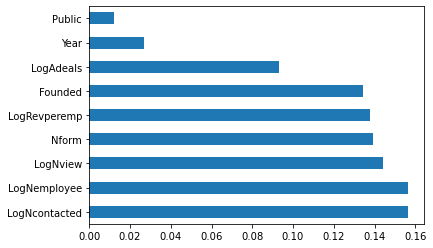

In [25]:
model = ExtraTreesClassifier()
model.fit(X1,y1)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X1.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

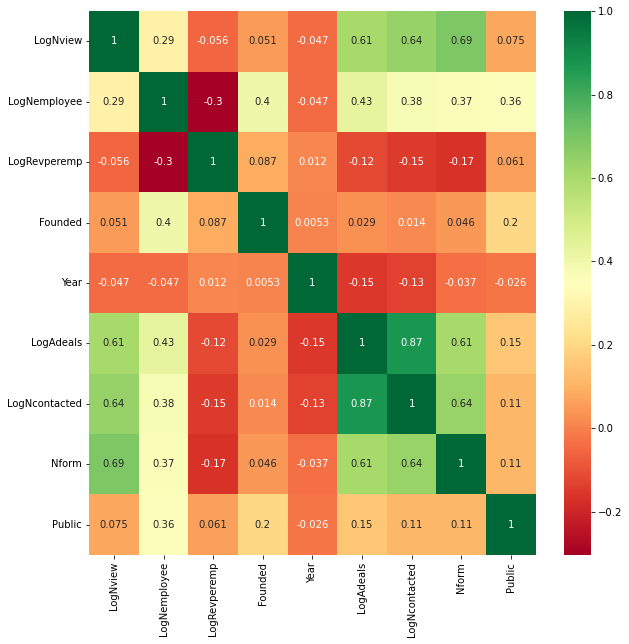

In [26]:
corrmat = X1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
#plot heat map
sns.heatmap(reg_data[top_corr_features].corr(), annot=True, cmap="RdYlGn");

            Specs        Score
7           Nform  3257.138873
6   LogNcontacted   157.774048
0        LogNview   117.735906
5       LogAdeals   111.701026
9          Medium     9.391963
1    LogNemployee     7.002722
2    LogRevperemp     3.673465
8          Public     2.200233
3         Founded     1.004334
10          Large     0.373381
[0.11501632 0.0881871  0.08882921 0.08473203 0.04613321 0.12510131
 0.306227   0.10906436 0.00935884 0.01829791 0.0090527 ]


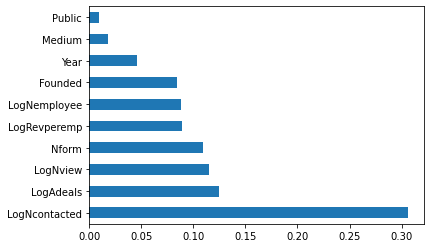

In [27]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X2,y2)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X2.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

model = ExtraTreesClassifier()
model.fit(X2,y2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X2.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

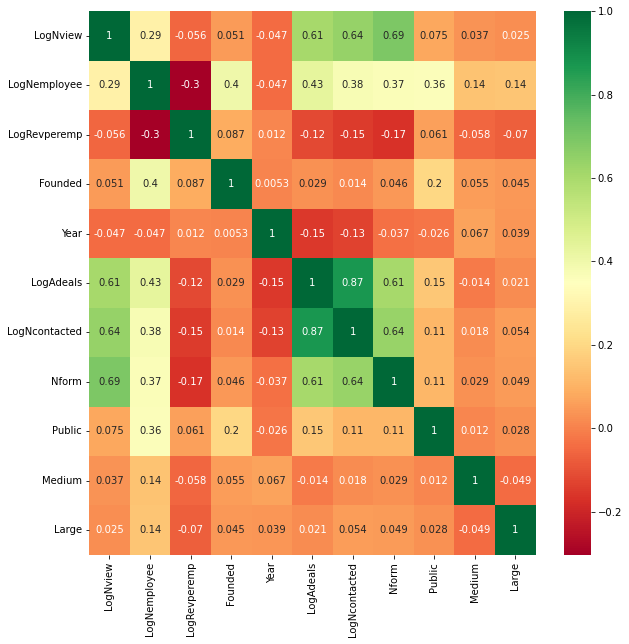

In [28]:
corrmat = X2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
#plot heat map
sns.heatmap(reg_data[top_corr_features].corr(), annot=True, cmap="RdYlGn");

## Regression of Size

In [29]:
# Baseline regression
reg_size1 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + Year',
                     data=reg_data).fit()
# print(reg_size1.summary())

# Add group fixed effects
reg_size2 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + Year + C(IndGroup)',
                    data=reg_data).fit()
# print(reg_size2.summary())

# Add geography dummy
reg_size3 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + Year + C(IndGroup) + USfirm',
                    data=reg_data).fit()
# print(reg_size3.summary())

In [30]:
ngroup = len(group_ind)
s = Stargazer([reg_size1, reg_size2, reg_size3])
s.covariate_order(['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp',
                   'Year', 'USfirm'] + ['C(IndGroup)[T.Group{}]'.format(i)
                                        for i in np.arange(2, ngroup + 1)])
s.rename_covariates({'C(IndGroup)[T.Group{}]'.format(i): 'IndGroup{}'.format(i) for i in np.arange(2, ngroup + 1)})
# s.add_custom_notes(['Regression (2) and (3) added industry fixed effects.'])
s.title('Regression of Size')
s

In [31]:
print(s.render_latex())

\begin{table}[!htbp] \centering
  \caption{Regression of Size}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & 1.595$^{***}$ & 1.807$^{***}$ & 1.870$^{***}$ \\
  & (0.145) & (0.245) & (0.249) \\
 LogNview & -0.042$^{***}$ & -0.038$^{***}$ & -0.036$^{***}$ \\
  & (0.012) & (0.013) & (0.013) \\
 LogNemployee & 0.090$^{***}$ & 0.089$^{***}$ & 0.089$^{***}$ \\
  & (0.012) & (0.012) & (0.012) \\
 LogRevperemp & -0.028$^{***}$ & -0.030$^{***}$ & -0.030$^{***}$ \\
  & (0.009) & (0.010) & (0.010) \\
 Year & 0.263$^{***}$ & 0.259$^{***}$ & 0.258$^{***}$ \\
  & (0.031) & (0.031) & (0.031) \\
 USfirm & & & -0.079$^{}$ \\
  & & & (0.052) \\
 IndGroup2 & & 0.372$^{}$ & 0.376$^{}$ \\
  & & (0.244) & (0.244) \\
 IndGroup3 & & -0.293$^{}$ & -0.288$^{}$ \\
  & & (0.227) & (0.227) \\
 IndGroup4 & & -0.172$^{}$ & -0.175$^{}$ \\
  & & (0.201) & (0

In [32]:
# Change reference group gi
gi = 2
reg_size_ref1 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + \
                         Year + C(IndGroup, Treatment(reference="Group{}"))'.format(gi),
                         data=reg_data).fit()
reg_size_ref2 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + \
                         Year + C(IndGroup, Treatment(reference="Group{}")) + USfirm'.format(gi),
                         data=reg_data).fit()

sref = Stargazer([reg_size_ref1, reg_size_ref2])
sref.covariate_order(['C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i)
                      for i in np.arange(1, ngroup + 1) if i != gi])

sref.rename_covariates({'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): \
                        'IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1) if i != gi})
sref

In [33]:
# Get FE coefficients given each reference group
ngroup = len(group_ind)
fe_coef_size = pd.DataFrame(columns=['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp', 'Year'] + \
                            ['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)])
for gi in np.arange(1, ngroup + 1):
    reg_size_ref1 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + \
                         Year + C(IndGroup, Treatment(reference="Group{}"))'.format(gi),
                         data=reg_data).fit()
    df = (pd.DataFrame(reg_size_ref1.params)
            .transpose()
            .rename(columns={'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): 'IndGroup{}'.format(i)
                             for i in np.arange(1, ngroup + 1) if i != gi},
                    index={0: 'RefGroup{}'.format(gi)}))
    fe_coef_size = pd.concat([fe_coef_size, df])

print(fe_coef_size[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  RefGroup1 &  RefGroup2 &  RefGroup3 &  RefGroup4 &  RefGroup5 &  RefGroup6 &  RefGroup7 &  RefGroup8 &  RefGroup9 &  RefGroup10 &  RefGroup11 \\
\midrule
IndGroup1  &        NaN &     -0.372 &      0.293 &      0.172 &      0.239 &      0.221 &      0.176 &      0.218 &      0.136 &       0.424 &       0.134 \\
IndGroup2  &      0.372 &        NaN &      0.665 &      0.544 &      0.611 &      0.593 &      0.548 &      0.590 &      0.508 &       0.796 &       0.506 \\
IndGroup3  &     -0.293 &     -0.665 &        NaN &     -0.121 &     -0.054 &     -0.072 &     -0.117 &     -0.075 &     -0.157 &       0.131 &      -0.158 \\
IndGroup4  &     -0.172 &     -0.544 &      0.121 &        NaN &      0.066 &      0.048 &      0.004 &      0.046 &     -0.036 &       0.251 &      -0.038 \\
IndGroup5  &     -0.239 &     -0.611 &      0.054 &     -0.066 &        NaN &     -0.018 &     -0.062 &     -0.021 &     -0.103 &       0.185 &      -0.104 \\
IndGro

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\3304692602.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fe_coef_size[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())


In [34]:
# Get FE coefficients given each reference group
ngroup = len(group_ind)
fe_coef_size = pd.DataFrame(columns=['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp', 'Year', 'USfirm'] + \
                            ['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)])
for gi in np.arange(1, ngroup + 1):
    reg_size_ref2 = smf.ols('LogSize ~ LogNview + LogNemployee + LogRevperemp + \
                         Year + C(IndGroup, Treatment(reference="Group{}")) + USfirm'.format(gi),
                         data=reg_data).fit()
    df = (pd.DataFrame(reg_size_ref2.params)
            .transpose()
            .rename(columns={'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): 'IndGroup{}'.format(i)
                             for i in np.arange(1, ngroup + 1) if i != gi},
                    index={0: 'RefGroup{}'.format(gi)}))
    fe_coef_size = pd.concat([fe_coef_size, df])

print(fe_coef_size[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  RefGroup1 &  RefGroup2 &  RefGroup3 &  RefGroup4 &  RefGroup5 &  RefGroup6 &  RefGroup7 &  RefGroup8 &  RefGroup9 &  RefGroup10 &  RefGroup11 \\
\midrule
IndGroup1  &        NaN &     -0.376 &      0.288 &      0.175 &      0.236 &      0.220 &      0.171 &      0.213 &      0.150 &       0.422 &       0.136 \\
IndGroup2  &      0.376 &        NaN &      0.665 &      0.551 &      0.612 &      0.596 &      0.547 &      0.589 &      0.526 &       0.798 &       0.512 \\
IndGroup3  &     -0.288 &     -0.665 &        NaN &     -0.114 &     -0.053 &     -0.068 &     -0.117 &     -0.076 &     -0.139 &       0.133 &      -0.153 \\
IndGroup4  &     -0.175 &     -0.551 &      0.114 &        NaN &      0.061 &      0.045 &     -0.004 &      0.038 &     -0.025 &       0.247 &      -0.039 \\
IndGroup5  &     -0.236 &     -0.612 &      0.053 &     -0.061 &        NaN &     -0.015 &     -0.065 &     -0.023 &     -0.086 &       0.186 &      -0.100 \\
IndGro

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\3499369328.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fe_coef_size[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())


## Regression of Acceptance

In [35]:
# Baseline regression
reg_acc1 = smf.gls('Binary ~ LogNview + LogNemployee + LogRevperemp + Year + Medium + Large',
                   family=sm.families.Binomial(),
                   data=reg_data).fit()
# print(reg_acc1.summary())

# Add industry fixed effects
reg_acc2 = smf.gls('Binary ~ LogNview + LogNemployee + LogRevperemp + Year + Medium + Large + C(IndGroup)',
                   family=sm.families.Binomial(),
                   data=reg_data).fit()
# print(reg_acc2.summary())

# Add geography dummy
reg_acc3 = smf.gls('Binary ~ LogNview + LogNemployee + LogRevperemp + Year + Medium + Large + C(IndGroup) + USfirm',
                   family=sm.families.Binomial(),
                   data=reg_data).fit()
# print(reg_acc3.summary())

C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


In [36]:
ngroup = len(group_ind)
s1 = Stargazer([reg_acc1, reg_acc2, reg_acc3])
s1.covariate_order(['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp',
                   'Year', 'Medium', 'Large', 'USfirm'] + ['C(IndGroup)[T.Group{}]'.format(i)
                                                           for i in np.arange(2, ngroup + 1)])
s1.rename_covariates({'C(IndGroup)[T.Group{}]'.format(i): 'IndGroup{}'.format(i) for i in np.arange(2, ngroup + 1)})
# s1.add_custom_notes(['Regression (2) and (3) added industry fixed effects.'])
s1.title('Regression of Acceptance')
s1

In [37]:
print(s1.render_latex())

\begin{table}[!htbp] \centering
  \caption{Regression of Acceptance}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & 0.276$^{***}$ & 0.135$^{}$ & 0.096$^{}$ \\
  & (0.078) & (0.133) & (0.135) \\
 LogNview & 0.115$^{***}$ & 0.115$^{***}$ & 0.114$^{***}$ \\
  & (0.007) & (0.007) & (0.007) \\
 LogNemployee & -0.005$^{}$ & -0.005$^{}$ & -0.005$^{}$ \\
  & (0.006) & (0.006) & (0.006) \\
 LogRevperemp & -0.018$^{***}$ & -0.016$^{***}$ & -0.016$^{***}$ \\
  & (0.005) & (0.005) & (0.005) \\
 Year & 0.033$^{*}$ & 0.034$^{**}$ & 0.035$^{**}$ \\
  & (0.017) & (0.017) & (0.017) \\
 Medium & -0.129$^{***}$ & -0.133$^{***}$ & -0.131$^{***}$ \\
  & (0.030) & (0.030) & (0.030) \\
 Large & -0.082$^{}$ & -0.079$^{}$ & -0.076$^{}$ \\
  & (0.055) & (0.055) & (0.055) \\
 USfirm & & & 0.048$^{*}$ \\
  & & & (0.028) \\
 IndGroup2 & & 0.129$^{}$ & 0.1

In [133]:
# Change reference group gi
gi = 11
reg_acc_ref1 = smf.gls('Binary ~ LogNview + LogNemployee + LogRevperemp + \
                        Year + Medium + Large + C(IndGroup, Treatment(reference="Group{}"))'.format(gi),
                       family=sm.families.Binomial(),
                       data=reg_data).fit()
reg_acc_ref2 = smf.gls('Binary ~ LogNview + LogNemployee + LogRevperemp + \
                        Year + Medium + Large + C(IndGroup, Treatment(reference="Group{}")) + USfirm'.format(gi),
                       family=sm.families.Binomial(),
                       data=reg_data).fit()

sref1 = Stargazer([reg_acc_ref1, reg_acc_ref2])
sref1.covariate_order(['C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i)
                       for i in np.arange(1, ngroup + 1) if i != gi])

sref1.rename_covariates({'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): \
                        'IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1) if i != gi})
sref1

C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


In [39]:
# Get FE coefficients given each reference group
ngroup = len(group_ind)
fe_coef_acc = pd.DataFrame(columns=['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp', 'Year', 'Medium', 'Large'] + \
                            ['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)])
for gi in np.arange(1, ngroup + 1):
    reg_acc_ref1 = smf.ols('Binary ~ LogNview + LogNemployee + LogRevperemp + \
                         Year + Medium + Large + C(IndGroup, Treatment(reference="Group{}"))'.format(gi),
                         data=reg_data).fit()
    df = (pd.DataFrame(reg_acc_ref1.params)
            .transpose()
            .rename(columns={'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): 'IndGroup{}'.format(i)
                             for i in np.arange(1, ngroup + 1) if i != gi},
                    index={0: 'RefGroup{}'.format(gi)}))
    fe_coef_acc = pd.concat([fe_coef_acc, df])

print(fe_coef_acc[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  RefGroup1 &  RefGroup2 &  RefGroup3 &  RefGroup4 &  RefGroup5 &  RefGroup6 &  RefGroup7 &  RefGroup8 &  RefGroup9 &  RefGroup10 &  RefGroup11 \\
\midrule
IndGroup1  &        NaN &     -0.129 &     -0.059 &     -0.163 &     -0.122 &     -0.138 &     -0.073 &     -0.075 &     -0.057 &      -0.098 &      -0.169 \\
IndGroup2  &      0.129 &        NaN &      0.070 &     -0.034 &      0.007 &     -0.009 &      0.056 &      0.054 &      0.072 &       0.031 &      -0.040 \\
IndGroup3  &      0.059 &     -0.070 &        NaN &     -0.104 &     -0.064 &     -0.080 &     -0.015 &     -0.016 &      0.002 &      -0.040 &      -0.111 \\
IndGroup4  &      0.163 &      0.034 &      0.104 &        NaN &      0.041 &      0.025 &      0.090 &      0.088 &      0.106 &       0.064 &      -0.006 \\
IndGroup5  &      0.122 &     -0.007 &      0.064 &     -0.041 &        NaN &     -0.016 &      0.049 &      0.047 &      0.065 &       0.024 &      -0.047 \\
IndGro

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\1723922037.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fe_coef_acc[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())


In [40]:
# Get FE coefficients given each reference group
ngroup = len(group_ind)
fe_coef_acc = pd.DataFrame(columns=['Intercept', 'LogNview', 'LogNemployee', 'LogRevperemp', 'Year', 'Medium', 'Large', 'USfirm'] + \
                            ['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)])
for gi in np.arange(1, ngroup + 1):
    reg_acc_ref2 = smf.ols('Binary ~ LogNview + LogNemployee + LogRevperemp + \
                        Year + Medium + Large + C(IndGroup, Treatment(reference="Group{}")) + USfirm'.format(gi),
                        data=reg_data).fit()
    df = (pd.DataFrame(reg_acc_ref2.params)
            .transpose()
            .rename(columns={'C(IndGroup, Treatment(reference="Group{}"))[T.Group{}]'.format(gi, i): 'IndGroup{}'.format(i)
                             for i in np.arange(1, ngroup + 1) if i != gi},
                    index={0: 'RefGroup{}'.format(gi)}))
    fe_coef_acc = pd.concat([fe_coef_acc, df])

print(fe_coef_acc[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  RefGroup1 &  RefGroup2 &  RefGroup3 &  RefGroup4 &  RefGroup5 &  RefGroup6 &  RefGroup7 &  RefGroup8 &  RefGroup9 &  RefGroup10 &  RefGroup11 \\
\midrule
IndGroup1  &        NaN &     -0.126 &     -0.056 &     -0.164 &     -0.120 &     -0.138 &     -0.070 &     -0.072 &     -0.065 &      -0.097 &      -0.170 \\
IndGroup2  &      0.126 &        NaN &      0.070 &     -0.038 &      0.006 &     -0.012 &      0.056 &      0.054 &      0.061 &       0.028 &      -0.044 \\
IndGroup3  &      0.056 &     -0.070 &        NaN &     -0.109 &     -0.064 &     -0.082 &     -0.014 &     -0.016 &     -0.009 &      -0.042 &      -0.114 \\
IndGroup4  &      0.164 &      0.038 &      0.109 &        NaN &      0.044 &      0.026 &      0.094 &      0.093 &      0.099 &       0.067 &      -0.006 \\
IndGroup5  &      0.120 &     -0.006 &      0.064 &     -0.044 &        NaN &     -0.018 &      0.050 &      0.049 &      0.055 &       0.023 &      -0.050 \\
IndGro

C:\Users\wz369\AppData\Local\Temp\ipykernel_10176\1730371859.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fe_coef_acc[['IndGroup{}'.format(i) for i in np.arange(1, ngroup + 1)]].transpose().round(3).to_latex())


## 2 Industry Groups Compasiron

In [42]:
groups

,IndGroup,Count,TotalAmount
0,Group1,21,5.195000e+05
1,Group2,35,1.714700e+06
2,Group3,55,1.282200e+06
3,Group4,227,5.444300e+06
4,Group5,308,7.624500e+06
5,Group6,1378,3.103520e+07
6,Group7,375,7.586700e+06
7,Group8,269,5.801778e+06
8,Group9,55,1.981900e+06
9,Group10,63,1.301900e+06


In [47]:
len(reg_data)//2 - 1378

233

In [95]:
21 + 35 + 55 + 55 + 63

229

In [161]:
# Define function to generate power sets of the industry group list
def powerset(iterable, l=0, u=0):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(l, len(s) + 1 - u))

# List of industry groups other than Group6
g_lst = list(range(1, len(groups) + 1))
g_lst.remove(6)

# The threshold of the count difference between the 2 clusters
diff = 100
lb, ub = 233 + diff, 233 - diff

# Find all the possible combinations for Cluster1 (containing Group6) given the threshold
cluster1 = []
for gs in powerset(g_lst, 1, 5):
    cnt = 0
    for g in gs:
        cnt += groups.loc[groups.IndGroup == 'Group{}'.format(g), 'Count'].values[0]
        if (cnt > lb) or (cnt < ub): break
    if (cnt > lb) or (cnt < ub): continue
    cluster1.append(['Group{}'.format(i) for i in gs] + ['Group6'])
cluster1

[['Group4', 'Group6'],
 ['Group5', 'Group6'],
 ['Group8', 'Group6'],
 ['Group4', 'Group9', 'Group6'],
 ['Group4', 'Group10', 'Group6'],
 ['Group8', 'Group9', 'Group6'],
 ['Group8', 'Group10', 'Group6']]

In [162]:
# Regression of Logsize / Acceptance on 2 clusters given formulas
def regression_cluster(reg_data, cluster1, formulas):
    reg_data1 = copy.copy(reg_data)
    res_size = []
    res_acc = []
    for c1 in cluster1:
        reg_data1['Cluster'] = np.where(reg_data.IndGroup.isin(c1), 'Cluster1', 'Cluster2')
        res_size.append(smf.ols(formulas['Size'], data=reg_data1).fit())
        res_acc.append(smf.gls(formulas['Acceptance'], family=sm.families.Binomial(), data=reg_data1).fit())

    rv = []
    for res in [res_size, res_acc]:
        s = Stargazer(res)
        s.rename_covariates({'C(Cluster)[T.Cluster2]': 'Cluster2'})
        s.custom_columns([' + '.join(c1) for c1 in cluster1], [1] * len(cluster1))
        rv.append(s)
    return rv

In [163]:
fs = {'Size': 'LogSize ~ C(Cluster)',
      'Acceptance': 'Binary ~ C(Cluster)'}
s_size, s_acc = regression_cluster(reg_data, cluster1, fs)
s_size

C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['f

In [164]:
s_acc

In [165]:
# Add control variables
fs_ctr = {'Size': 'LogSize ~ LogNview + LogNemployee + LogRevperemp + Year + C(Cluster) + USfirm',
          'Acceptance': 'Binary ~ LogNview + LogNemployee + LogRevperemp + Year + Medium + Large + C(Cluster) + USfirm'}
s_size_ctr, s_acc_ctr = regression_cluster(reg_data, cluster1, fs_ctr)
s_size_ctr

C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
C:\Users\wz369\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['f

In [166]:
s_acc_ctr

Choose Group4(Information) & Group6(Computer Software) as one cluster.

In [132]:
reg_data1 = copy.copy(reg_data)
c1 = ['Group4', 'Group6']
reg_data1['Cluster'] = np.where(reg_data.IndGroup.isin(c1), 'Cluster1', 'Cluster2')
reg_data1.groupby('Cluster').agg(Count=('Size', 'count'),
                                 TotalAmount=('Amount', 'sum'))

,Count,TotalAmount
Cluster,,
Cluster1,1605,3.647950e+07
Cluster2,1618,3.777388e+07


In [173]:
print(s_size_ctr.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{7}{c}{\textit{Dependent variable:}} \
\cr \cline{7-8}
\\[-1.8ex] & \multicolumn{1}{c}{Group4 + Group6} & \multicolumn{1}{c}{Group5 + Group6} & \multicolumn{1}{c}{Group8 + Group6} & \multicolumn{1}{c}{Group4 + Group9 + Group6} & \multicolumn{1}{c}{Group4 + Group10 + Group6} & \multicolumn{1}{c}{Group8 + Group9 + Group6} & \multicolumn{1}{c}{Group8 + Group10 + Group6}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) \\
\hline \\[-1.8ex]
 Cluster2 & 0.033$^{}$ & 0.055$^{*}$ & 0.045$^{}$ & 0.030$^{}$ & 0.051$^{}$ & 0.042$^{}$ & 0.063$^{**}$ \\
  & (0.031) & (0.031) & (0.031) & (0.031) & (0.031) & (0.031) & (0.032) \\
 Intercept & 1.649$^{***}$ & 1.636$^{***}$ & 1.650$^{***}$ & 1.648$^{***}$ & 1.639$^{***}$ & 1.648$^{***}$ & 1.643$^{***}$ \\
  & (0.152) & (0.152) & (0.152) & (0.153) & (0.152) & (0.152) & (0.152) \\
 LogNemployee & 0.090$^{***}$ & 0.091$^{**